## Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, models, initializers, utils, callbacks
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from IPython.display import display
import glob
import random
from sklearn.preprocessing import StandardScaler, normalize
import plotly.graph_objects as go
import os
os.chdir('../')
data_dir = '.\data\\brain_mri\kaggle_3m'

In [2]:
%pwd

'c:\\Projects\\python\\brain_tumor_segmentation'

## Data Exploration

In [3]:
metadata1 = pd.read_csv(filepath_or_buffer='./data/brain_mri/kaggle_3m/data_mask.csv')
metadata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [4]:
metadata1['patient_id'].nunique()

110

In [5]:
print(f"\nImage path: {metadata1.image_path[1]},\nMask Path: {metadata1.mask_path[1]}")


Image path: TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,
Mask Path: TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif


In [6]:
metadata1['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

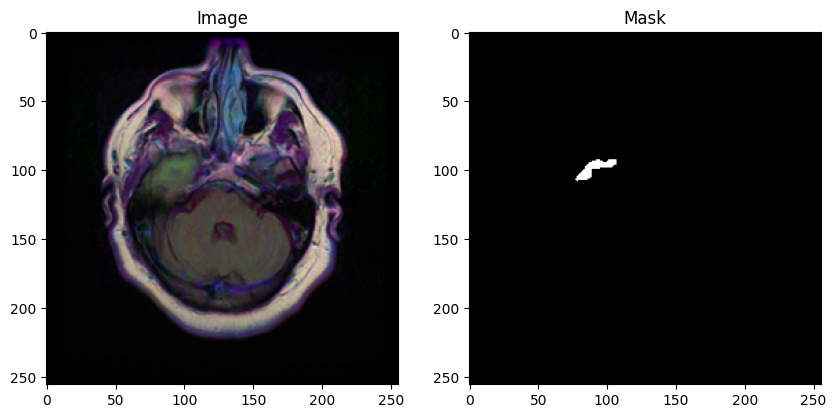

In [7]:
img = cv2.imread(os.path.join('.\data\\brain_mri\kaggle_3m',metadata1.image_path[623]))
mask = cv2.imread(os.path.join('.\data\\brain_mri\kaggle_3m',metadata1.mask_path[623]))

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)
plt.title("Mask")

plt.show()

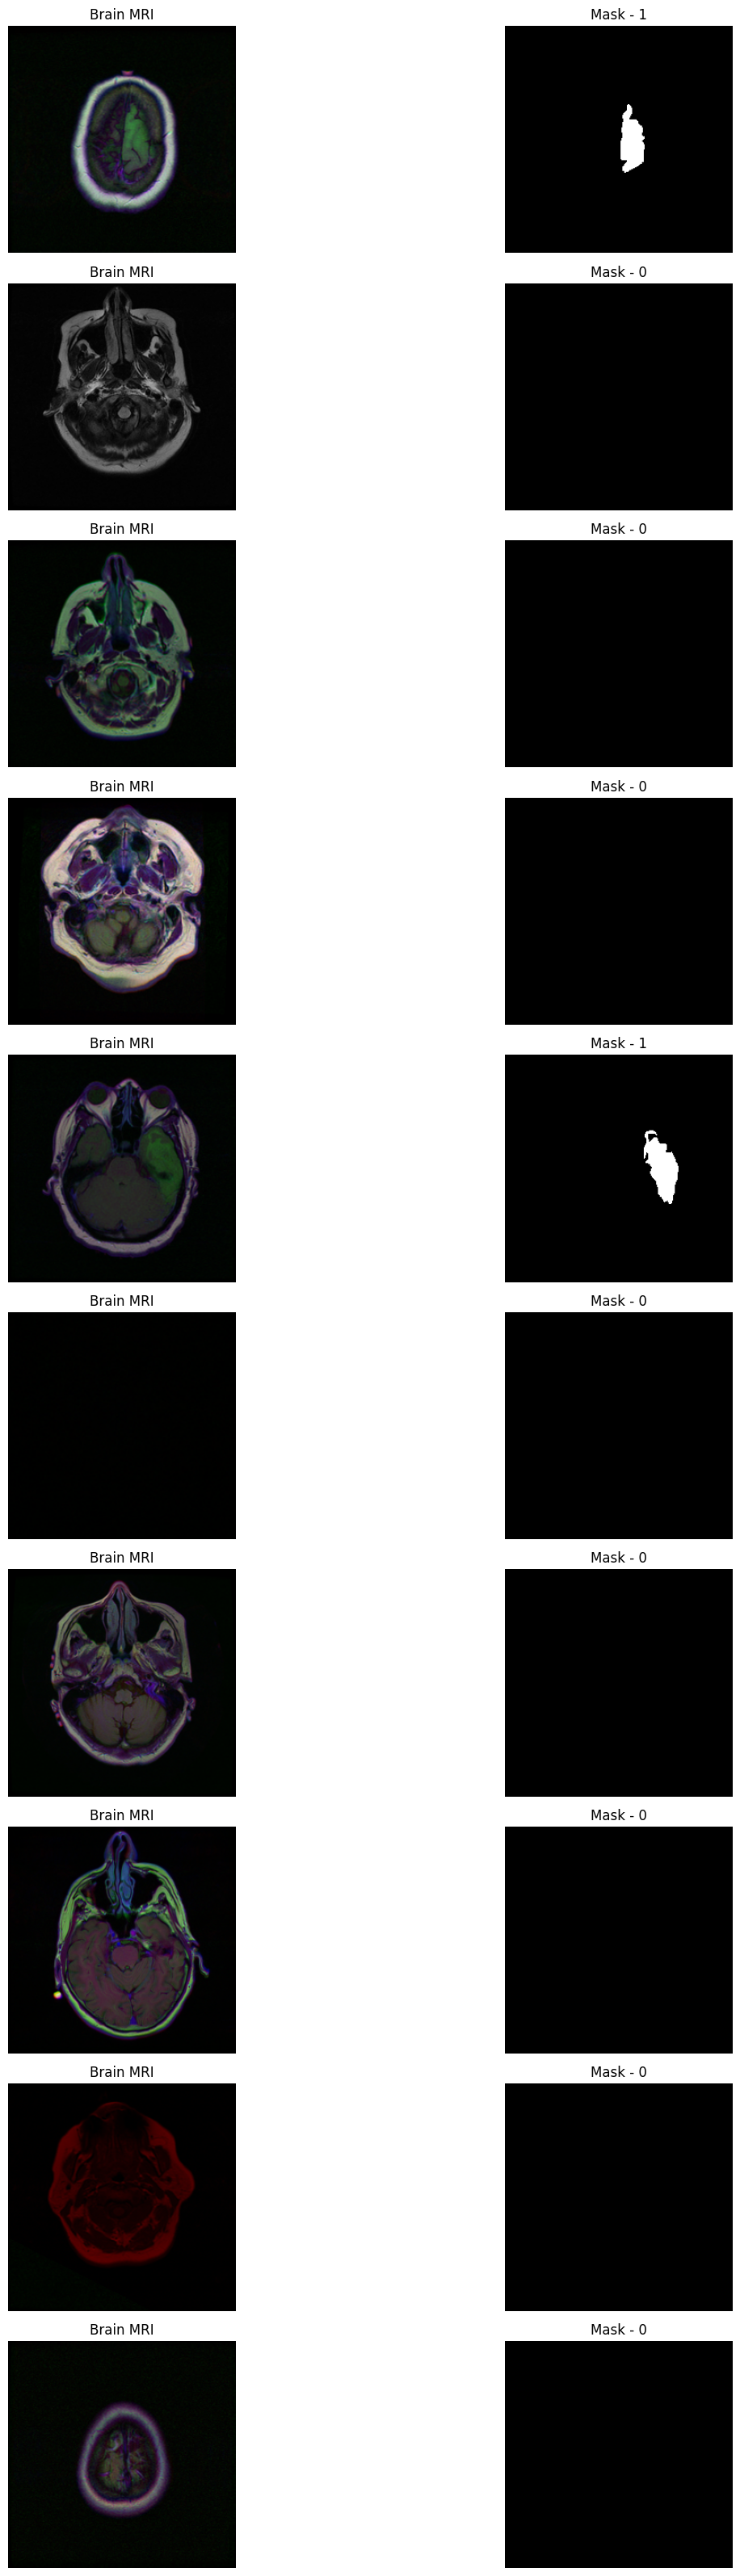

In [8]:
fig, axs = plt.subplots(10, 2, figsize=(16, 32))

for idx in range(10):

    i = random.randint(0, len(metadata1) - 1)

    mri = cv2.imread(os.path.join(data_dir,metadata1.image_path[i]))
    mask = cv2.imread(os.path.join(data_dir,metadata1.mask_path[i]))

    mri_rgb = cv2.cvtColor(mri, cv2.COLOR_BGR2RGB) if mri is not None else None
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) if mask is not None else None

    axs[idx, 0].set_title("Brain MRI")
    axs[idx, 1].set_title(f"Mask - {metadata1['mask'][i]}")

    # Display images
    axs[idx, 0].imshow(mri_rgb)
    axs[idx, 1].imshow(mask_rgb)

    # Hide axes
    axs[idx, 0].axis("off")
    axs[idx, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

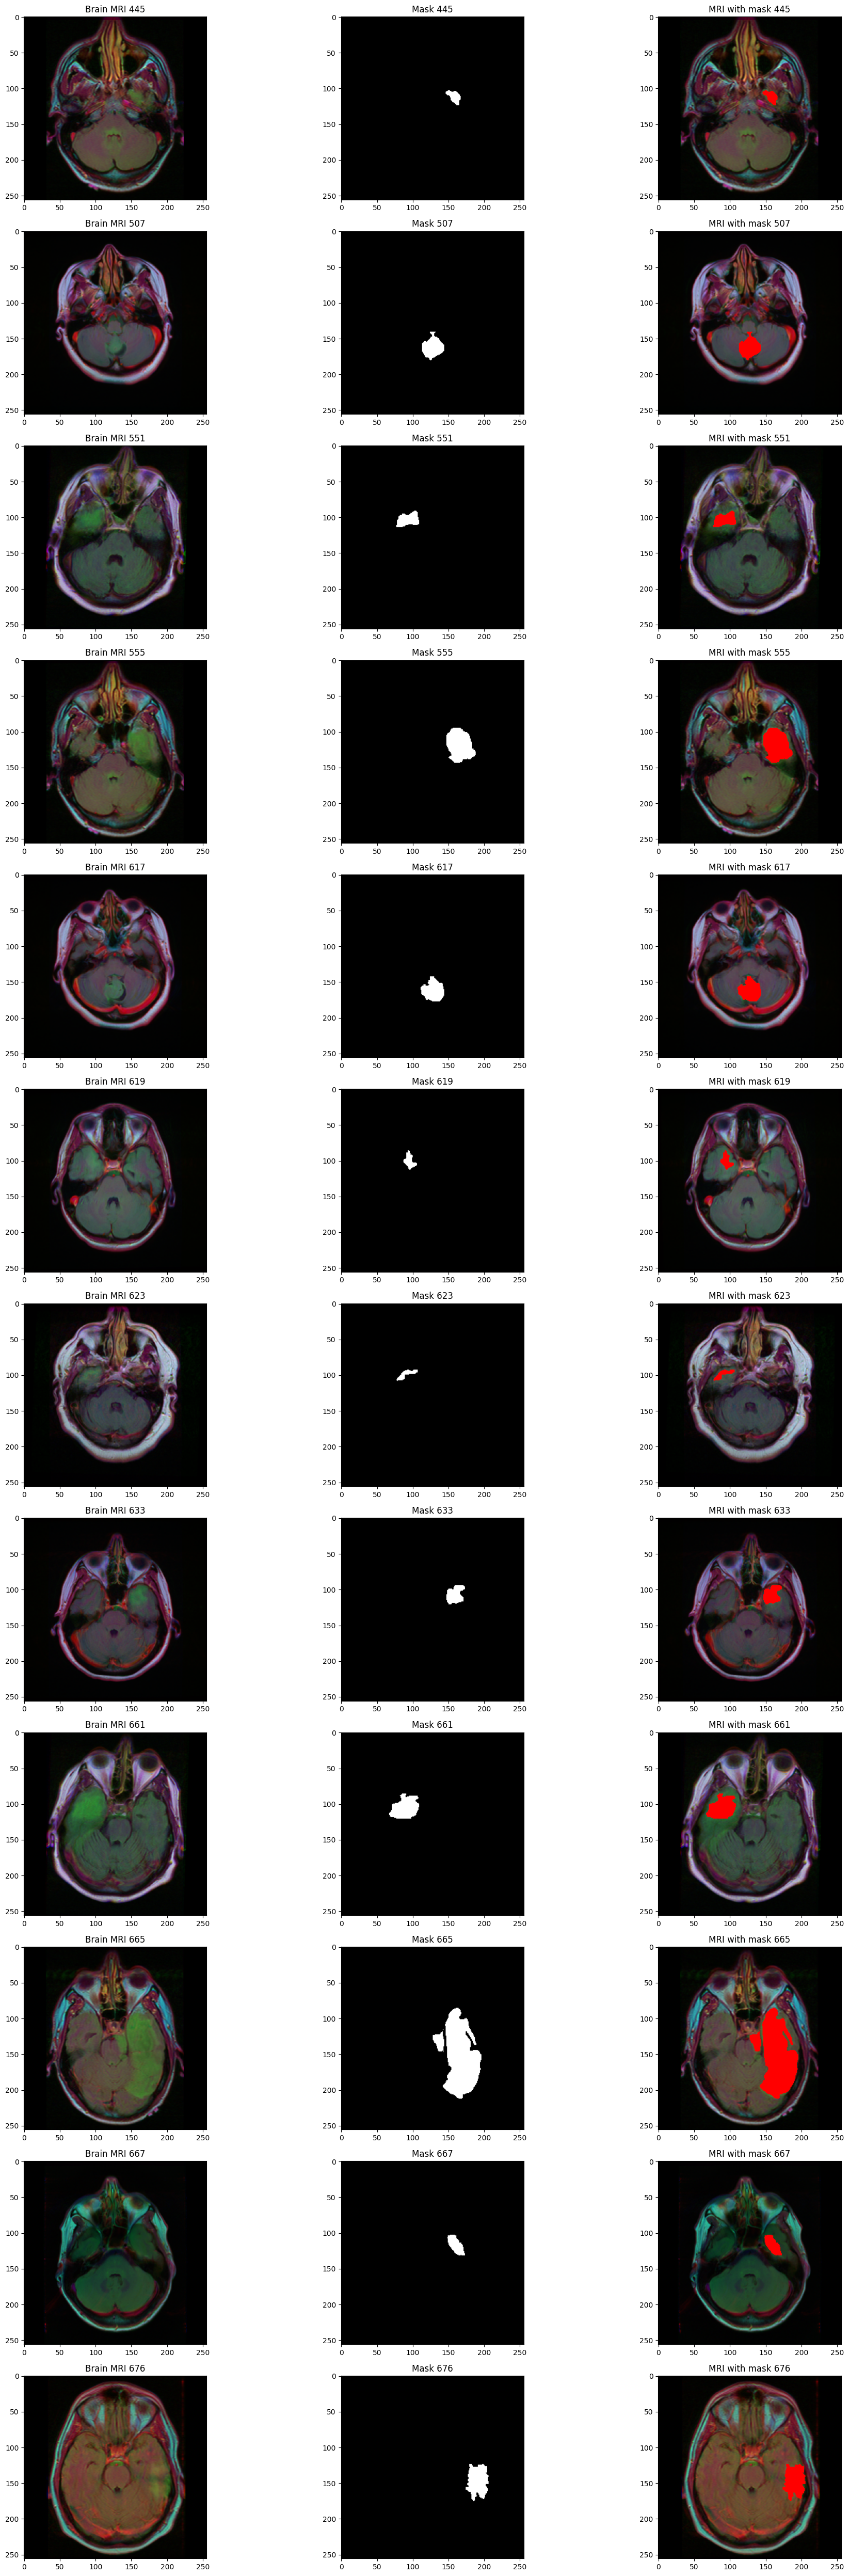

In [9]:
## Mask overlap
count = 0
fig,axs = plt.subplots(12,3,figsize=(20,50))
for i in range(len(metadata1)):
    if metadata1['mask'][i]==1 and count<12:
        img = cv2.imread(os.path.join(data_dir,metadata1.image_path[i]), cv2.COLOR_BGR2RGB)
        axs[count][0].title.set_text(f"Brain MRI {i}")
        axs[count][0].imshow(img)

        mask = cv2.imread(os.path.join(data_dir,metadata1.mask_path[i]), cv2.COLOR_BGR2RGB)
        axs[count][1].title.set_text(f"Mask {i}")
        axs[count][1].imshow(mask,cmap='gray')

        img[mask == 255] = (255,0,0)
        axs[count][2].title.set_text(f"MRI with mask {i}")
        axs[count][2].imshow(img)
        count+=1
fig.tight_layout()

#### Observation:

- The dataset contains 3929 unique image-mask pairs.
- These pairs are distributed among 110 patients.
- There is a slight imbalance in the dataset, where number of benign images exceed that of it's counterpart.

In [10]:
metadata2 = pd.read_csv(filepath_or_buffer='./data/brain_mri/kaggle_3m/data.csv')
metadata2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

## Data Preprocessing

In [11]:
# converting the categorical column into str
metadata1['mask'] = metadata1['mask'].apply(lambda x: str(x))

In [12]:
# train-test-split
from sklearn.model_selection import train_test_split

train, test=train_test_split(metadata1,test_size=0.15)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 3486 to 2682
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  590 non-null    object
 1   image_path  590 non-null    object
 2   mask_path   590 non-null    object
 3   mask        590 non-null    object
dtypes: object(4)
memory usage: 23.0+ KB


In [14]:
# creating image generator: scale the data from 0 to 1 and making validation split
from keras_preprocessing.image import ImageDataGenerator
datagenerator = ImageDataGenerator(rescale=1./255.,validation_split=0.15)

trainset_generator = datagenerator.flow_from_dataframe(
    dataframe=train,
    directory=data_dir,
    x_col='image_path',
    y_col='mask',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256,256)
)

validset_generator = datagenerator.flow_from_dataframe(
    dataframe=train,
    directory=data_dir,
    x_col='image_path',
    y_col='mask',
    subset='validation',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256,256)
)

test_datagenerator = ImageDataGenerator(rescale=1./255.)

testset_generator = test_datagenerator.flow_from_dataframe(
    dataframe=test,
    directory=data_dir,
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256,256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


## Base Model

In [15]:
## Load the base ResNet50 classifier model for imagenet dataset
base = ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

In [16]:
base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
# freeze the model weights
for layer in base.layers:
    layers.trainable = False

# Add a classification layer at the end

classifier_head = base.output
classifier_head = AveragePooling2D(pool_size=(4,4))(classifier_head)
classifier_head = Flatten(name='flatten')(classifier_head)
classifier_head = Dense(256,activation='relu')(classifier_head)
classifier_head = Dropout(0.3)(classifier_head)
classifier_head = Dense(256,activation='relu')(classifier_head)
classifier_head = Dropout(0.3)(classifier_head)
classifier_head = Dense(2,activation='softmax')(classifier_head)

model = Model(inputs=base.input,outputs = classifier_head)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
# compile the model
model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# using early stopping to exit training if loss is not decreasing
earlystopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier-resnet.weights.h5',verbose=1,save_best_only=True,save_weights_only=True)

In [ ]:
# training the classifier
history = model.fit(trainset_generator,
                    steps_per_epoch=trainset_generator.n//16,
                    epochs=1,
                    validation_data=validset_generator,
                    validation_steps=validset_generator.n //16,
                    callbacks=[checkpointer,earlystopping])

In [ ]:
# save the model architecture to json file for future use
model_json = model.to_json()
with open('classifier-resnet.weights.h5','w') as json_file:
    json_file.write(model_json)